<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/Subgroups_characterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)
mushroom_df = pd.DataFrame(data=mushroom.data.features)
# mushroom_df.head()

def preprocess_mushroom_data(df):

    mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

    for column, mapping in mapping.items():
        df[column] = df[column].replace(mapping)

    return df

mushroom_df = preprocess_mushroom_data(mushroom_df).astype(str)

for column in mushroom_df.columns:
    split_columns = column.split("-")
    jointed_columns = ' '.join(split_columns)
    mushroom_df[column] = mushroom_df[column].apply(lambda x: f"{jointed_columns} is {x}")

In [59]:
#Aglomerative clustering

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec


sentences = []
for i in range(len(mushroom_df)):
    sentence = []
    for word in mushroom_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

def sentence_embedding(sentence, model):
    word_embeddings = []
    for word in sentence:
        word_embeddings.append(model.wv[word])
    return np.mean(word_embeddings, axis=0)

model = Word2Vec(sentences, min_count=1, vector_size=20, window=5)
embeddings = np.array([sentence_embedding(sentence, model) for sentence in sentences])

labels_aglomerative_average = AgglomerativeClustering(n_clusters= 23, metric = 'cosine', linkage='average').fit_predict(embeddings)


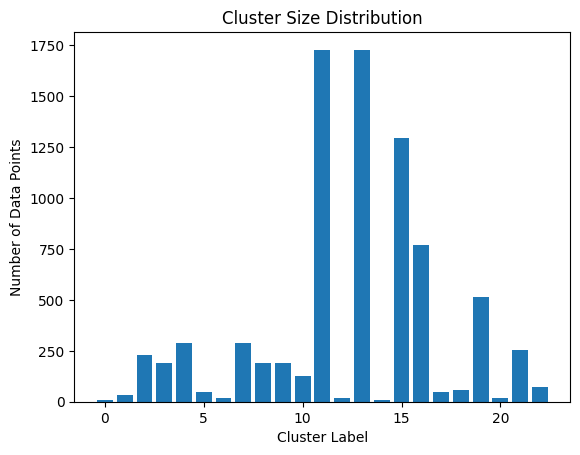

In [60]:
cluster_counts = {}
for label in labels_aglomerative_average:
    cluster_counts[label] = cluster_counts.get(label, 0) + 1

cluster_sizes = list(cluster_counts.values())
cluster_labels = list(cluster_counts.keys())

plt.bar(cluster_labels, cluster_sizes)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Data Points")
plt.title("Cluster Size Distribution")
plt.show()

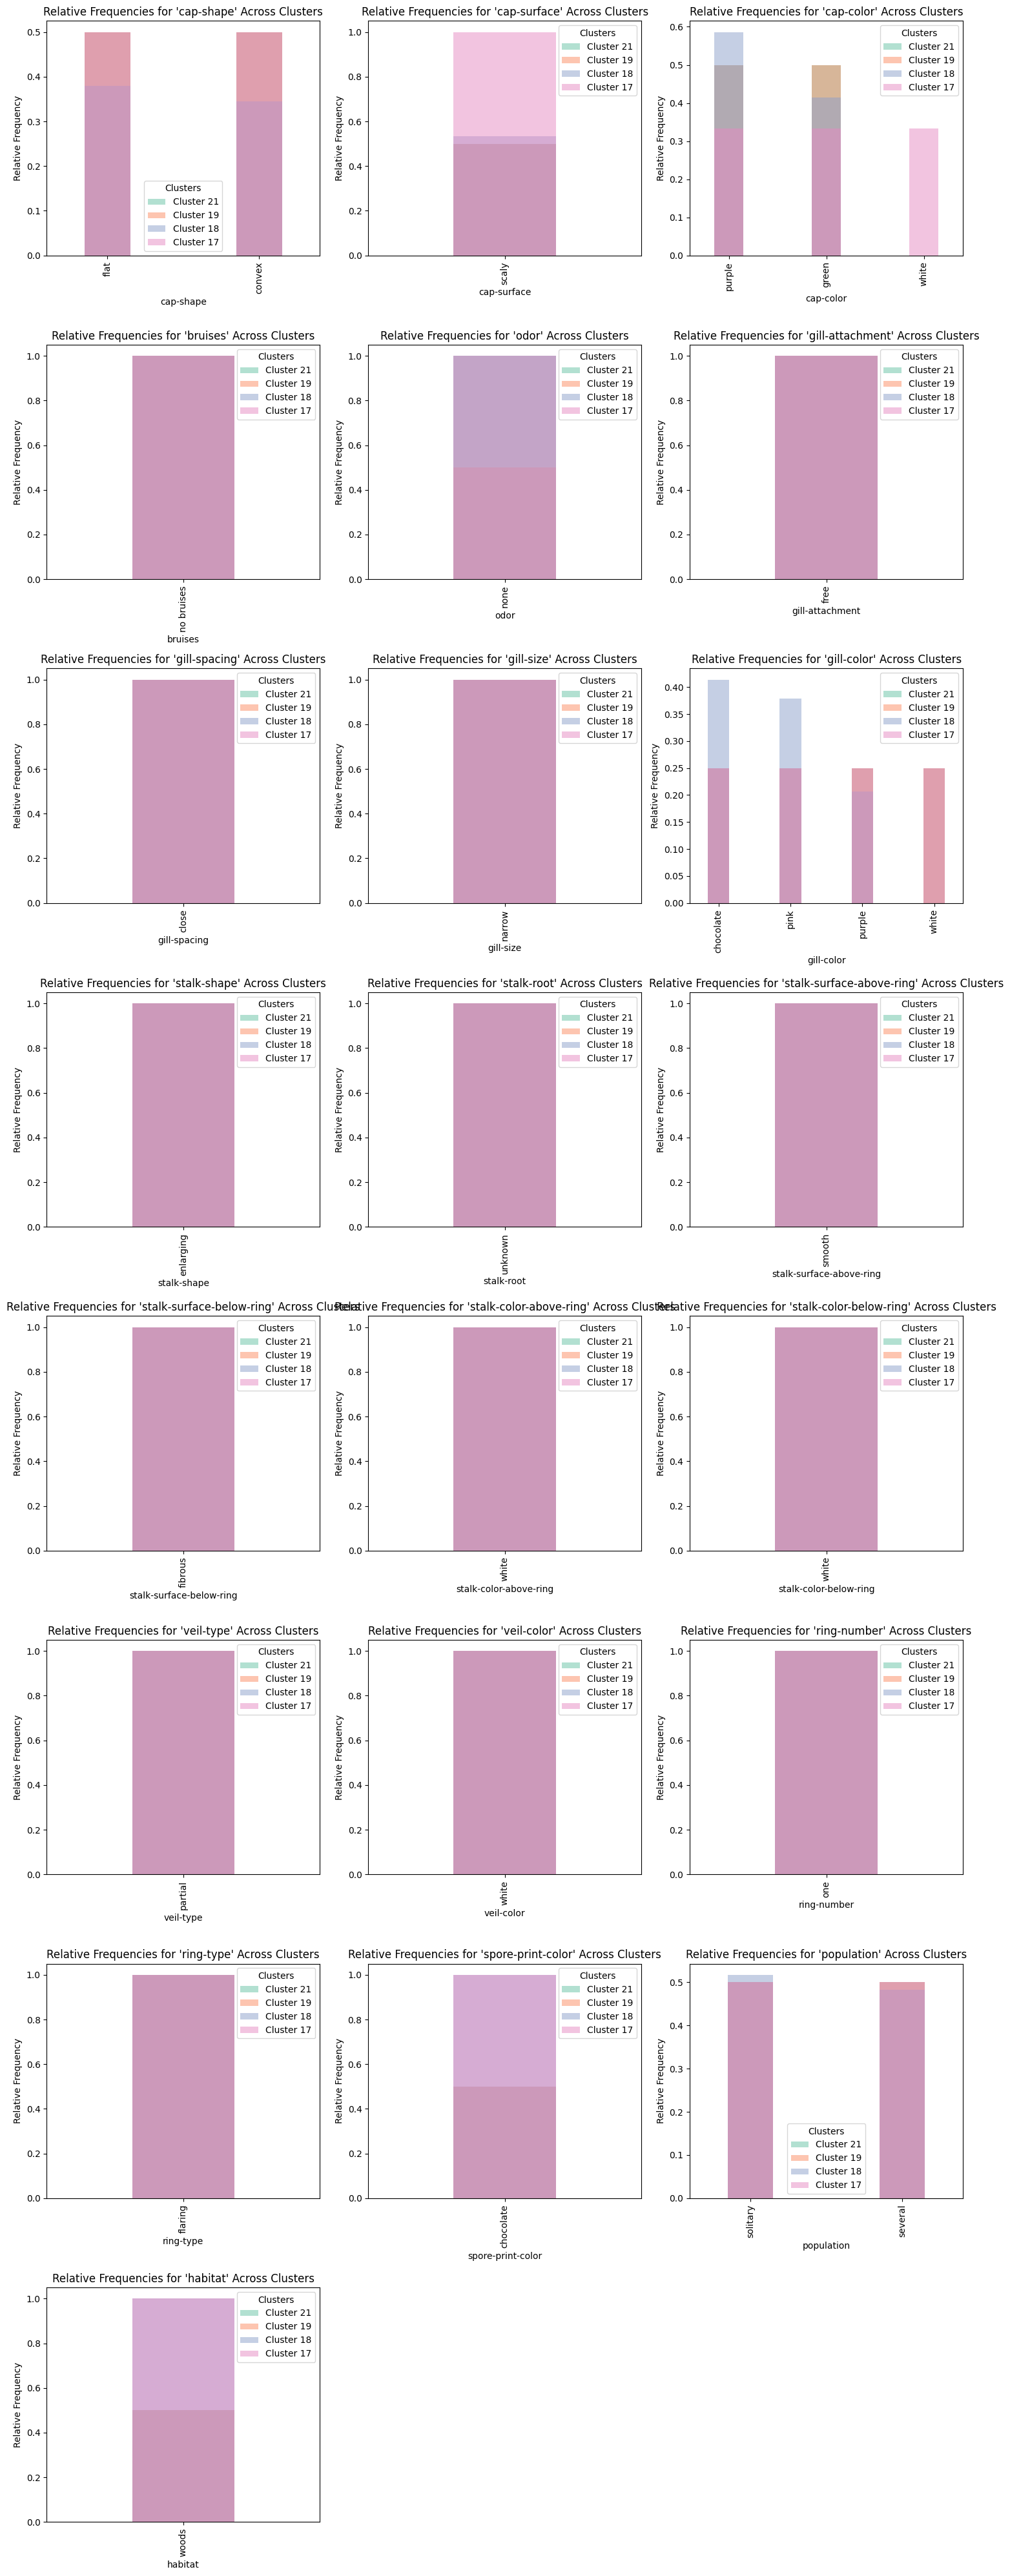

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
mushroom_raw = pd.DataFrame(data=mushroom.data.features)
mushroom_raw = preprocess_mushroom_data(mushroom_raw)
mushroom_raw = mushroom_raw.fillna('unknown')




cluster_indexes_dict = {label: [] for label in set(labels_aglomerative_average)}

for i, label in enumerate(labels_aglomerative_average):
    cluster_indexes_dict[label].append(i)

color_palette = sns.color_palette("Set2", len(cluster_indexes_dict))

def compare_relative_frequencies(dataset, cluster_indexes_dict):

    num_columns = 3
    num_rows = (len(dataset.columns) + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    for i, col in enumerate(dataset.columns):
        ax = axes[i]
        plots_made = False
        for idx, (cluster_label, cluster_indices) in enumerate(cluster_indexes_dict.items()):
            if len(cluster_indices) > 0:
                cluster_data = dataset.loc[cluster_indices]

                cluster_data[col].dtype == 'object'
                value_counts = cluster_data[col].value_counts(normalize=True)
                value_counts.plot(kind='bar',
                                      alpha=0.5,
                                      label=f"Cluster {cluster_label}",
                                      color=color_palette[idx],
                                      width=0.3, ax=ax)
                plots_made = True

        if plots_made:
            ax.set_title(f"Relative Frequencies for '{col}' Across Clusters")
            ax.set_xlabel(col)
            ax.set_ylabel('Relative Frequency')
            ax.legend(title="Clusters")
        else:
            ax.set_title(f"No data to compare for column '{col}'")


    for i in range(len(dataset.columns), len(axes)):
        fig.delaxes(axes[i])


    plt.tight_layout()
    plt.show()


compare_relative_frequencies(mushroom_raw, {
    21: cluster_indexes_dict[21],
    19: cluster_indexes_dict[19],
    18: cluster_indexes_dict[18],
    17: cluster_indexes_dict.get(17, [])
})



In [62]:
from collections import Counter

cluster_indexes_dict = {label: [] for label in set(cluster_labels)}
for i, label in enumerate(cluster_labels):
    cluster_indexes_dict[label].append(i)

def most_common(list):
    data = Counter(list)
    return data.most_common(1)[0][0]

def compare_most_common_elements(dataset, cluster_indexes):

    for cluster_label, cluster_indices in cluster_indexes.items():
        cluster_data = dataset.loc[cluster_indices]
        most_common_elements = {}
        for col in cluster_data.columns:
            most_common_elements[col] = most_common(cluster_data[col])

        print(f"Most common elements in cluster {cluster_label}:")
        for col, most_common_val in most_common_elements.items():
            print(f"  {col}: {most_common_val}")



comparison_indexes_dict = {key: cluster_indexes_dict[key] for key in [12,13]}


compare_most_common_elements(mushroom_raw, comparison_indexes_dict)



Most common elements in cluster 12:
  cap-shape: bell
  cap-surface: scaly
  cap-color: yellow
  bruises: bruises
  odor: anise
  gill-attachment: free
  gill-spacing: close
  gill-size: broad
  gill-color: black
  stalk-shape: enlarging
  stalk-root: club
  stalk-surface-above-ring: smooth
  stalk-surface-below-ring: smooth
  stalk-color-above-ring: white
  stalk-color-below-ring: white
  veil-type: partial
  veil-color: white
  ring-number: one
  ring-type: pendant
  spore-print-color: brown
  population: scattered
  habitat: meadows
Most common elements in cluster 13:
  cap-shape: bell
  cap-surface: smooth
  cap-color: white
  bruises: bruises
  odor: almond
  gill-attachment: free
  gill-spacing: close
  gill-size: broad
  gill-color: gray
  stalk-shape: enlarging
  stalk-root: club
  stalk-surface-above-ring: smooth
  stalk-surface-below-ring: smooth
  stalk-color-above-ring: white
  stalk-color-below-ring: white
  veil-type: partial
  veil-color: white
  ring-number: one
  ring-

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text

mushroom_classify = mushroom_raw.assign(cluster = labels_aglomerative_average)

encoder = OneHotEncoder()
X = mushroom_classify.drop(columns=['cluster'])
X_encoded = encoder.fit_transform(mushroom_classify[['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat' ]]).toarray()
y = mushroom_classify['cluster']
X_df = pd.DataFrame(X, columns=encoder.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=73)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        42
           4       1.00      1.00      1.00        61
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00        57
           8       1.00      1.00      1.00        45
           9       1.00      1.00      1.00        44
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00       329
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00       358
          15       1.00      1.00      1.00       268
          16       1.00      1.00      1.00       136
          17       1.00      1.00      1.00        10
          18 

In [64]:
print(export_text(clf, feature_names = list(X_df.columns)))


|--- gill-color_buff <= 0.50
|   |--- ring-type_large <= 0.50
|   |   |--- habitat_woods <= 0.50
|   |   |   |--- ring-type_evanescent <= 0.50
|   |   |   |   |--- stalk-root_club <= 0.50
|   |   |   |   |   |--- stalk-shape_enlarging <= 0.50
|   |   |   |   |   |   |--- class: 7
|   |   |   |   |   |--- stalk-shape_enlarging >  0.50
|   |   |   |   |   |   |--- odor_pungent <= 0.50
|   |   |   |   |   |   |   |--- stalk-root_rooted <= 0.50
|   |   |   |   |   |   |   |   |--- stalk-color-below-ring_orange <= 0.50
|   |   |   |   |   |   |   |   |   |--- stalk-root_unknown <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- habitat_urban <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- habitat_urban >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |   |   |   |--- stalk-root_unknown >  0.50
|   |   |   |   |   |   |   |   |   |   |--- stalk-surface-above-ring_silky

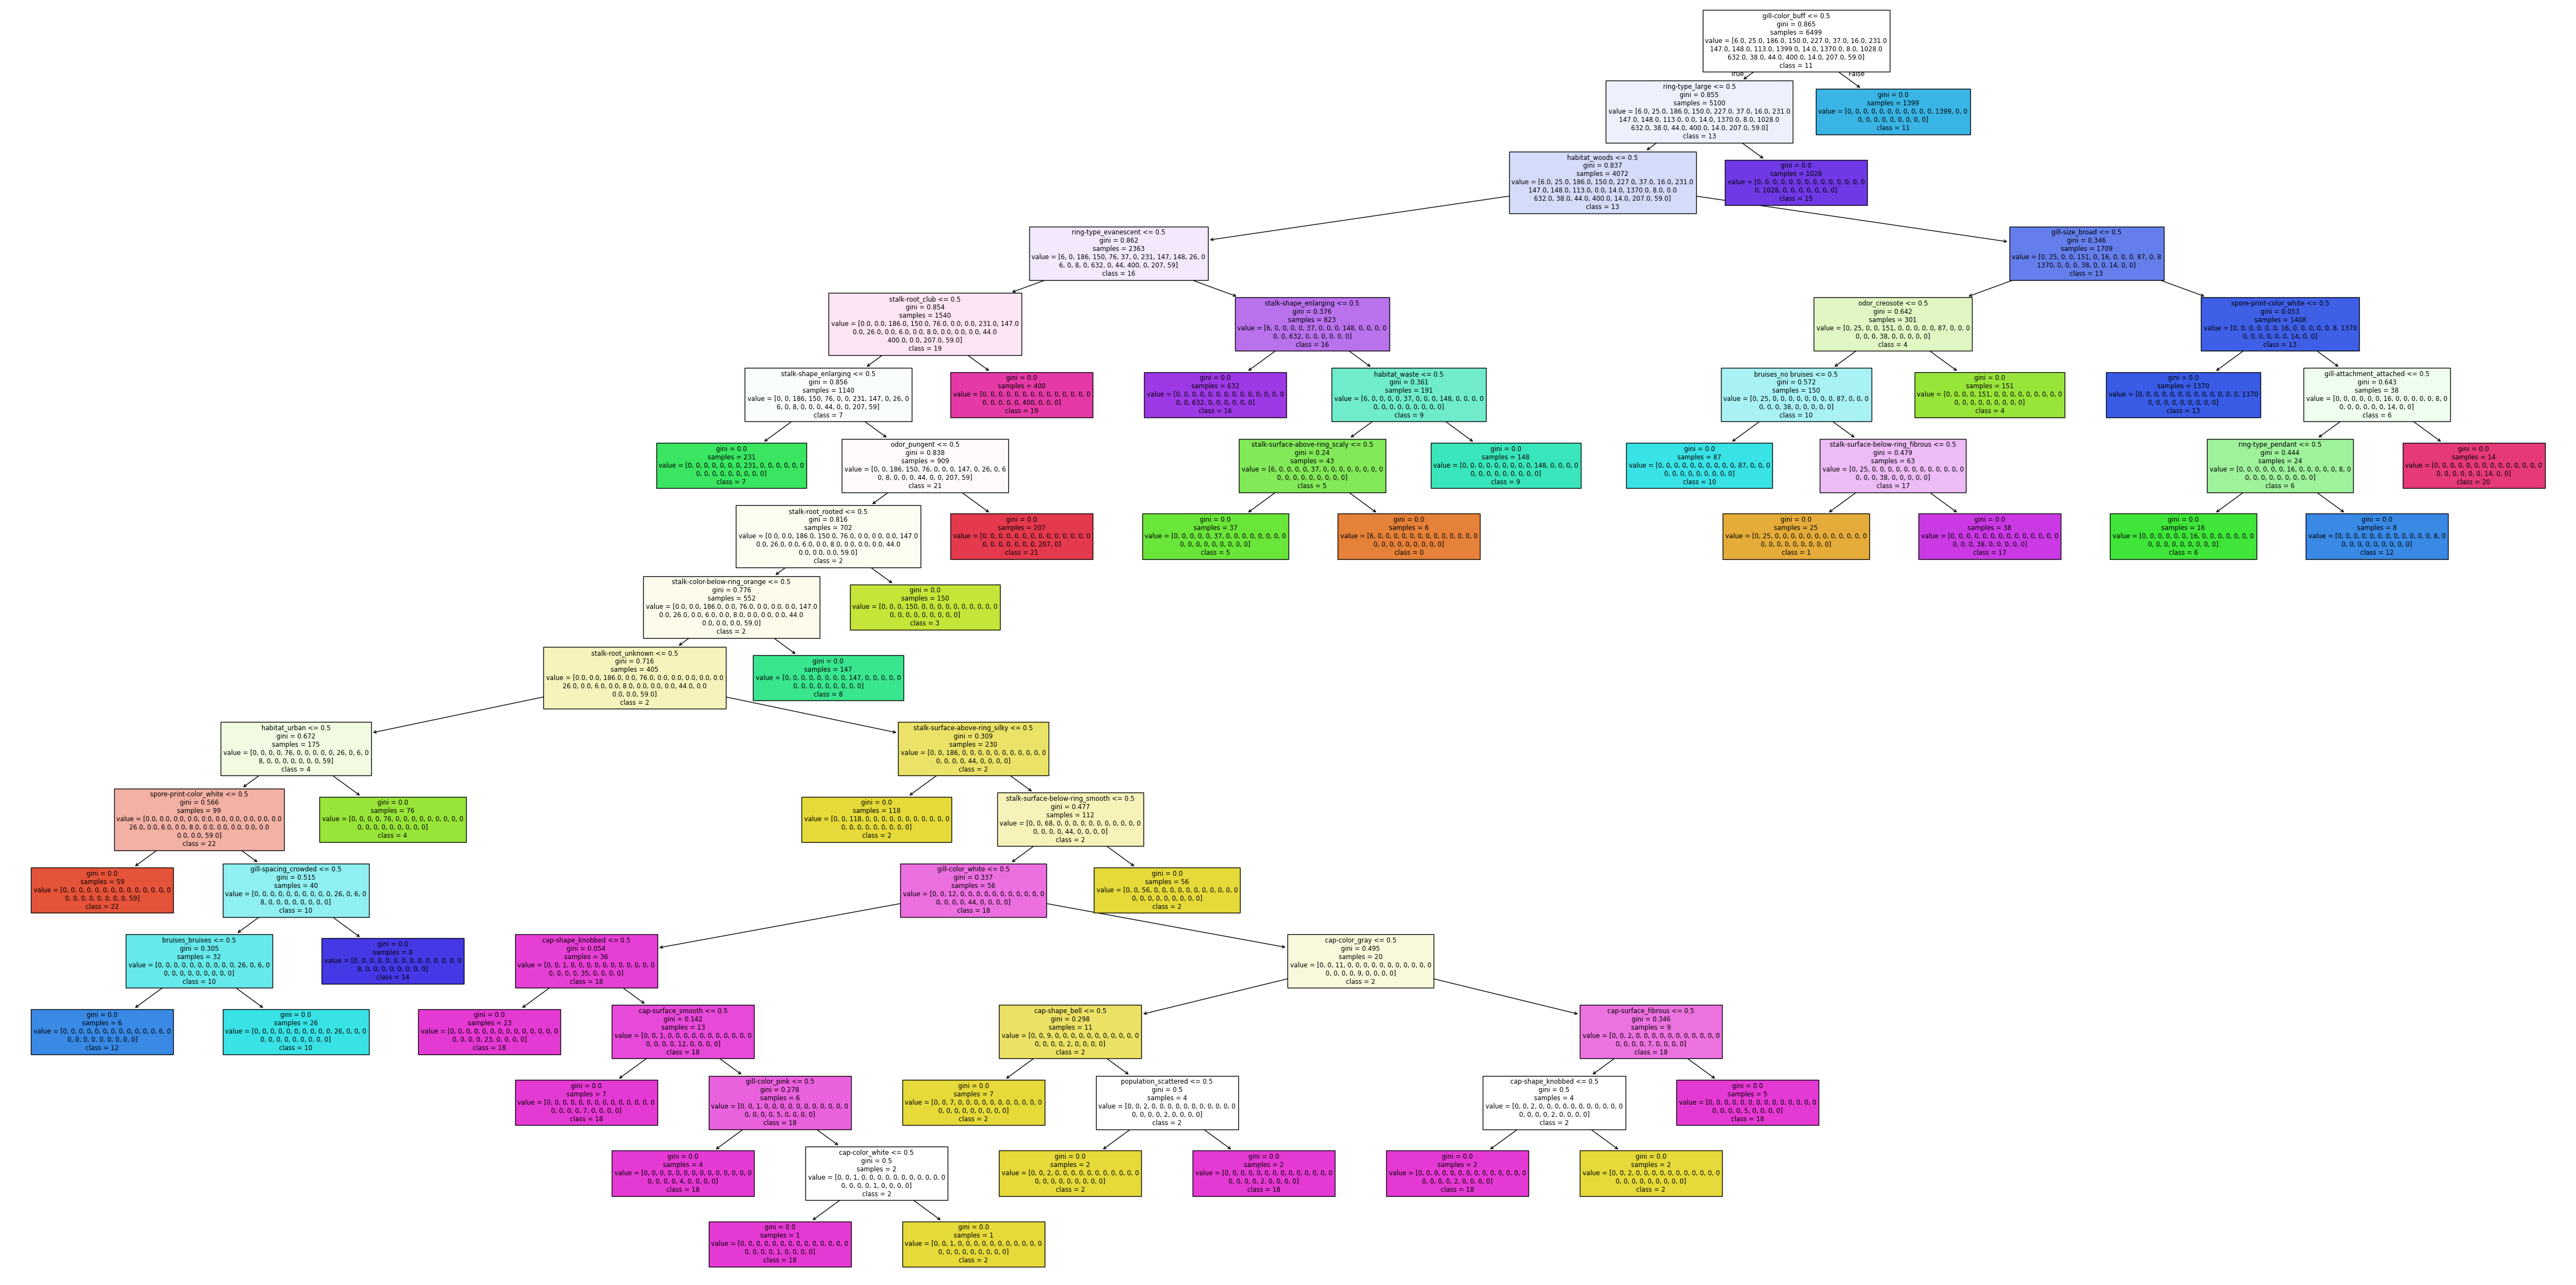

'decision_tree.pdf'

In [65]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import matplotlib.pyplot as plt
import graphviz

plt.figure(figsize=(60, 30))
clusters_str = [str(c) for c in clf.classes_]
plot_tree(clf, filled=True, feature_names=list(X_df.columns), class_names=clusters_str)
plt.show()

dot_data = export_graphviz(clf, out_file=None,
                                feature_names=list(X_df.columns),
                                class_names=clusters_str,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")